<a href="https://colab.research.google.com/github/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/blob/main/8_RNN_sol_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Recurrentes (RNN)

Continuando con el estudio de las redes profundas, las redes recurrentes poseen la caracteristicas de guardar la información previa y entregarsela a la siguiente capa, con el fin de mantener la información secuencial de los datos.

![texto del vínculo](https://www.simplilearn.com/ice9/free_resources_article_thumb/Fully_connected_Recurrent_Neural_Network.gif)

In [1]:
!pip install -q nltk

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Symptom2Disease ([Link](https://www.kaggle.com/datasets/niyarrbarman/symptom2disease))




In [5]:
dat = pd.read_csv('https://raw.githubusercontent.com/MaxWesterhout/Sistemas-de-Diagnostico-y-Tratamiento-I/refs/heads/main/data/Symptom2DiseaseClase8.csv')
dat.head()

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."


In [6]:
#24 Labels
dat['label'].value_counts()

,count
label,
Psoriasis,50
Varicose Veins,50
Typhoid,50
Chicken pox,50
Impetigo,50
Dengue,50
Fungal infection,50
Common Cold,50
Pneumonia,50


In [7]:
dat['text'][0]

'I have been experiencing a skin rash on my arms, legs, and torso for the past few weeks. It is red, itchy, and covered in dry, scaly patches.'

## Preprocesamiento

codigo de preprocesamiento modificado desde [kaggle](https://www.kaggle.com/code/yannansu/symptom2disease-with-neural-networks-92-accuracy#Build-and-train-model)

### Label Encoder

In [8]:
# Convierte nuestras etiquetas en numeros
label_encoder = LabelEncoder()
label_encoder.fit(dat['label'])
label_sequences = label_encoder.transform(dat['label'])

dat['label_encoded'] = label_sequences
dat['label_encoded']

,label_encoded
0,15
1,15
2,15
3,15
4,15
...,...
1195,19
1196,19
1197,19
1198,19


In [9]:
# Nuestro dataset ahora posee esa columna extra
dat

,Unnamed: 0,label,text,label_encoded
0,0,Psoriasis,I have been experiencing a skin rash on my arm...,15
1,1,Psoriasis,"My skin has been peeling, especially on my kne...",15
2,2,Psoriasis,I have been experiencing joint pain in my fing...,15
3,3,Psoriasis,"There is a silver like dusting on my skin, esp...",15
4,4,Psoriasis,"My nails have small dents or pits in them, and...",15
...,...,...,...,...
1195,295,diabetes,I'm shaking and trembling all over. I've lost ...,19
1196,296,diabetes,"Particularly in the crevices of my skin, I hav...",19
1197,297,diabetes,I regularly experience these intense urges and...,19
1198,298,diabetes,"I have trouble breathing, especially outside. ...",19


### Train - Test split

In [10]:
train_ratio = 0.8
# sample 80% of the data for training and 20% for validation for each label
train = dat.groupby('label_encoded', group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))
val = dat.drop(train.index)

train_texts = train['text'].values
train_labels = train['label_encoded'].values
val_texts = val['text'].values
val_labels = val['label_encoded'].values

train_texts.shape, train_labels.shape, val_texts.shape, val_labels.shape

<ipython-input-10-602544770ced>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = dat.groupby('label_encoded', group_keys=False).apply(lambda x: x.sample(frac=train_ratio, random_state=42))


((960,), (960,), (240,), (240,))

### Remover stopwords

In [11]:
# Tipos de stopword en nltk (primeras 10)
stopwords.words('english')[:10]

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']

In [15]:
# Funcion que utilizaremos para remover las stop words
def remove_stopwords(texts):
  # first remove all punctuations
  words = [re.split(r'[ ,.]+', text) for text in texts]

  # remove space and make all words lower case
  words = [[word.lower() for word in text if word != ''] for text in words]

  # remove stop words using nltk (or you can use your own stop words, see below)
  stop_words = set(stopwords.words('english'))

  words = [[word for word in text if word.lower() not in stop_words] for text in words]
  return words

print(train_texts[0])
# test the function
print(remove_stopwords(train_texts)[0])

A nasty rash has just appeared on my skin. Blackheads and pimples packed with pus are everywhere. Additionally, my skin has been extremely sensitive.
['nasty', 'rash', 'appeared', 'skin', 'blackheads', 'pimples', 'packed', 'pus', 'everywhere', 'additionally', 'skin', 'extremely', 'sensitive']


In [12]:
# make a tokenizer
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(train_texts)

def tokenize_and_pad(words, tokenizer, max_len=50):
    # convert the text to sequences of integers
    sequences = tokenizer.texts_to_sequences(words)
    # pad the sequences using the maxlen to make all sequences the same length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post')
    return padded_sequences

# test the function
print(train_texts[0], end="\n\n")
print(len(train_texts[0].split(" ")), end="\n\n")
tokenize_and_pad(train_texts, tokenizer)[0]

A nasty rash has just appeared on my skin. Blackheads and pimples packed with pus are everywhere. Additionally, my skin has been extremely sensitive.

24



array([  5, 287,  46,  13, 177, 562,  22,   3,  16, 133,   2,  92, 637,
        24, 134,  18, 400,  89,   3,  16,  13,   6,  98, 269,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [13]:
print(tokenizer.word_index)
print(len((tokenizer.word_index)))

{'<OOV>': 1, 'and': 2, 'my': 3, 'i': 4, 'a': 5, 'been': 6, 'have': 7, "i've": 8, 'of': 9, 'the': 10, 'to': 11, 'is': 12, 'has': 13, 'also': 14, 'in': 15, 'skin': 16, 'lot': 17, 'are': 18, 'really': 19, 'pain': 20, 'it': 21, 'on': 22, "i'm": 23, 'with': 24, 'fever': 25, 'that': 26, 'feeling': 27, 'me': 28, 'high': 29, 'feel': 30, 'experiencing': 31, 'neck': 32, 'having': 33, 'when': 34, 'there': 35, 'had': 36, 'get': 37, 'chest': 38, "it's": 39, 'am': 40, 'all': 41, 'for': 42, 'cough': 43, 'headache': 44, 'as': 45, 'rash': 46, 'quite': 47, 'up': 48, 'hurts': 49, 'throat': 50, 'severe': 51, 'red': 52, 'some': 53, 'body': 54, 'painful': 55, 'itching': 56, 'from': 57, 'very': 58, 'this': 59, 'weak': 60, 'chills': 61, 'over': 62, 'or': 63, 'back': 64, 'like': 65, 'difficult': 66, 'lost': 67, 'stomach': 68, 'coughing': 69, 'time': 70, 'discomfort': 71, 'frequently': 72, 'recently': 73, 'muscles': 74, 'nausea': 75, 'uncomfortable': 76, 'go': 77, 'exhausted': 78, 'legs': 79, 'occasionally': 80

In [16]:
# Notar que nuestro conjunto de prueba no tiene stop words y esta tokenizada con pad
train_sequences = tokenize_and_pad(remove_stopwords(train_texts), tokenizer)
train_labels = train_labels.reshape(-1, 1)

val_sequences = tokenize_and_pad(remove_stopwords(val_texts), tokenizer)
val_labels = val_labels.reshape(-1, 1)

print('train_sequences shape: ', train_sequences.shape)
print('train_labels shape: ', train_labels.shape)
print('val_sequences shape: ', val_sequences.shape)
print('val_labels shape: ', val_labels.shape)

train_sequences shape:  (960, 50)
train_labels shape:  (960, 1)
val_sequences shape:  (240, 50)
val_labels shape:  (240, 1)


In [17]:
def plot_graphs(history, metric):
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(history.history[metric])
    ax.plot(history.history['val_'+metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.title(metric)
    plt.show()

## Modelos

![texto del vínculo](https://miro.medium.com/v2/resize:fit:720/format:webp/1*LfH52lSd1mq-UrWuejzO8g.png)

In [18]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
def get_callbacks():
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    return [reduce_lr, early_stop]

In [19]:
max_length = len(train_sequences[0]) # 50

# Construcción del modelo con capa GRU
model_GRU = tf.keras.Sequential([
    tf.keras.Input(shape=(max_length,)),  # Especifica la forma de entrada
    tf.keras.layers.Embedding(input_dim=3000, output_dim=256),
    tf.keras.layers.GRU(64, go_backwards=True),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')  # Para clasificación multiclase
])

# Mostrar la arquitectura del modelo
model_GRU.summary()

# Compilación del modelo
model_GRU.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 256)        │       768,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 832,696 (3.18 MB)

 Trainable params: 832,696 (3.18 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model_GRU.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels), callbacks=get_callbacks())

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.1444 - loss: 3.1584 - val_accuracy: 0.3708 - val_loss: 3.0399 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3563 - loss: 2.8754 - val_accuracy: 0.2458 - val_loss: 2.3338 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4689 - loss: 1.9363 - val_accuracy: 0.6500 - val_loss: 1.4274 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8394 - loss: 0.9933 - val_accuracy: 0.8000 - val_loss: 0.9435 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9576 - loss: 0.4808 - val_accuracy: 0.8333 - val_loss: 0.7214 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9854 - loss: 0.2325 - val_accuracy: 0.8333 - val_loss: 0.6542 - learning_rate: 0.0010
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9959 - loss: 0.1383 - val_accuracy:

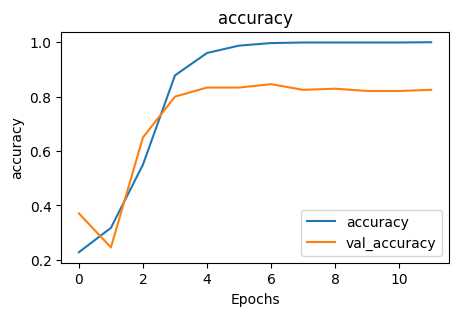

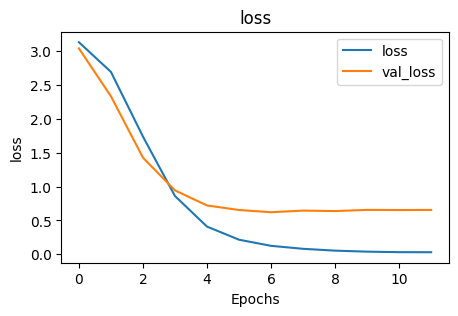

In [21]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Actividad 1
Visualice la evolución de los pesos de la predicción al añadir secuencialmente palabras como input Ej:



```
Frase : I've just developed a skin rash with several pus-filled pimples and blackheads.

Input 1: I've
Input 2: I've just
Input 3: I've just developed
...
Input N: I've just developed a skin rash with several pus-filled pimples and blackheads.
```



### Explicación detallada

In [23]:
# Como funciona la funcion remove stop words y tokenizar con pad
# Ejemplo de prueba: Frase 100 del dataset
frase_100 = dat["text"][100]

# Printeamos la frase
print(frase_100) # Hay que notar que la frase es una oracion completa, donde todo es una cadena

# Tratemos quitar las stops words de esta frase, con la misma funcion de arriba
frase_100_sin_stop_words_incorrecta = remove_stopwords(frase_100)
print(frase_100_sin_stop_words_incorrecta[0:10])

I have constipation and belly pain, and it's been really uncomfortable. The belly pain has been getting worse and is starting to affect my daily life. Moreover, I get chills every night, followed by a mild fever.
[[], [], ['h'], [], ['v'], ['e'], [], ['c'], [], ['n']]


Hay que notar que el ultimo resultado fue separado por letras, lo cual no es deseable para este caso dado que entrenamos el modelo por palabras (volver a ver sección tokenizacion). Esta separación sucede específicamente en la línea de código "words = [re.split(r'[ ,.]+', text) for text in texts]" de la función remove_stopwords, en donde esta función está esperando que se ingrese la oración en formato de lista, por ello veamos cómo es la correcta implementación.

In [24]:
frase_100_lista = [frase_100] # Convertimos a lista
# LLamamos la funcion remove_stopwords
frase_100_sin_stop_words_correcta = remove_stopwords(frase_100_lista)
print(frase_100_sin_stop_words_correcta[0])

['constipation', 'belly', 'pain', 'really', 'uncomfortable', 'belly', 'pain', 'getting', 'worse', 'starting', 'affect', 'daily', 'life', 'moreover', 'get', 'chills', 'every', 'night', 'followed', 'mild', 'fever']


Teniendo la frase lista sin stop words, podemos pasar a tokenizar. El código de arriba es estándar, en donde se debe llamar el tokenizador y el largo que uno desea convertir los vectores de entrada.

In [25]:
# Se inicializa el tokenizador
tokenizer = Tokenizer(oov_token="<OOV>")
# El tokenizador se ajusta con el vocabulario (palabras diferentes), del conjunto de entrenamiento
tokenizer.fit_on_texts(train_texts)

# Esto convierte la lista con palabras, en lista con numeros, siendo cada numero el token asociado
sequences = tokenizer.texts_to_sequences(frase_100_sin_stop_words_correcta)
print(sequences)

# Esto convierte la lista anterior, en una lista de tamaño especifico, siendo 50 el tamaño escogido para este problema
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post')[0]
print(padded_sequences)
print(f'El largo del vector con pad es: {len(padded_sequences)}')

[[190, 320, 20, 19, 76, 320, 20, 135, 137, 217, 1276, 437, 524, 383, 37, 61, 224, 121, 676, 180, 25]]
[ 190  320   20   19   76  320   20  135  137  217 1276  437  524  383
   37   61  224  121  676  180   25    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
El largo del vector con pad es: 50


Con todo esto la actividad se resume a ver cómo podemos alterar la cantidad de palabras de la lista de entrada del modelo, en donde existen múltiples métodos desde cambiar el vector con pad, hasta alterar la lista sin stop words.

In [26]:
# Alterar lista pad -> Ejemplo hasta la tercera frase
print(padded_sequences[0:3])

# Alterar oracion inicial -> Ejemplo hasta la tercera frase
print(frase_100_sin_stop_words_correcta[0][0:3])

[190 320  20]
['constipation', 'belly', 'pain']


Ahora referente a cómo utilizar esto para obtener las predicciones, se puede realizar lo siguiente:

In [29]:
# Frase de prueba con 3 palabras
frase_100 = dat["text"][100]
frase_100_lista = [frase_100] # Convertimos a lista

# Frase sin stop words
frase_100_sin_stop_words_correcta = remove_stopwords(frase_100_lista)[0]

# Frase recortada
frase_100_recortada = frase_100_sin_stop_words_correcta[0:3]
print(frase_100_recortada)

# Tokenizacion
sequences_ejemplo = tokenizer.texts_to_sequences([frase_100_recortada])

# Pad a tamaño 50
padded_sequences = pad_sequences(sequences_ejemplo, maxlen=50, padding='post')[0]

# Input del modelo
input = np.expand_dims(padded_sequences, axis=0) # Notar que el vector input, debe tener dos dimensiones <batch, data> [si batch = None lo toma como 1]

# Prediccion del modelo
pred = model_GRU.predict(input)
print(pred)

['constipation', 'belly', 'pain']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[[6.0268134e-02 1.6691242e-03 9.3983477e-03 9.1132923e-04 6.6313483e-03
  2.9645259e-03 6.5212920e-03 1.5033244e-01 3.9253896e-03 1.9553693e-02
  9.2583592e-04 7.7586336e-04 6.4808908e-03 3.1358519e-04 1.1651565e-02
  6.1180945e-03 1.8901865e-01 4.8080936e-01 1.5887256e-03 1.6259823e-03
  2.7928750e-03 1.3067161e-02 1.5112452e-02 7.5432123e-03]]


Esta salida es compleja de entender, pero corresponde al mapeo de probabilidades de cada clase, en donde cada número corresponde a la probabilidad de que la clase de dicho índice sea la clasificación (índice 0 corresponde a la clase 0). Ahora, esta probabilidad no necesariamente es la correcta, en donde este resultado corresponde únicamente a la predicción de nuestro modelo. Para obtener la clasificación final tomamos la probabilidad mayor:

In [31]:
# Retorna valor mayor del vector entregado
Prediccion_indice = np.argmax(pred)
print(f'Indice prediccion: {Prediccion_indice}')

# Nombre de la etiqueta asociada al indice
label_encoder.inverse_transform([np.argmax(pred).tolist()])
print(f'La prediccion es: {label_encoder.inverse_transform([np.argmax(pred).tolist()])}')

# La etiqueta real era
print(f'La etiqueta real era: {dat["label"][100]}')

Indice prediccion: 17
La prediccion es: ['Varicose Veins']
La etiqueta real era: Typhoid


Como vemos, nuestro modelo predijo mal con únicamente tres palabras, veamos como clasifica con todas las palabras de la oración 10.

In [33]:
# Frase completa
print(frase_100_sin_stop_words_correcta)

# Tokenizacion
sequences_ejemplo = tokenizer.texts_to_sequences([frase_100_sin_stop_words_correcta])

# Pad a tamaño 50
padded_sequences = pad_sequences(sequences_ejemplo, maxlen=50, padding='post')[0]

# Input del modelo
input = np.expand_dims(padded_sequences, axis=0) # Notar que el vector input, debe tener dos dimensiones <batch, data> [si batch = None lo toma como 1]

# Prediccion del modelo
pred = model_GRU.predict(input)

# Retorna valor mayor del vector entregado
Prediccion_indice = np.argmax(pred)
print(f'Indice prediccion: {Prediccion_indice}')

# Nombre de la etiqueta asociada al indice
label_encoder.inverse_transform([np.argmax(pred).tolist()])
print(f'La prediccion es: {label_encoder.inverse_transform([np.argmax(pred).tolist()])}')

# La etiqueta real era
print(f'La etiqueta real era: {dat["label"][100]}')

['constipation', 'belly', 'pain', 'really', 'uncomfortable', 'belly', 'pain', 'getting', 'worse', 'starting', 'affect', 'daily', 'life', 'moreover', 'get', 'chills', 'every', 'night', 'followed', 'mild', 'fever']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Indice prediccion: 16
La prediccion es: ['Typhoid']
La etiqueta real era: Typhoid


Ahora el resultado si es el correcto.

### Pauta actividad: 1

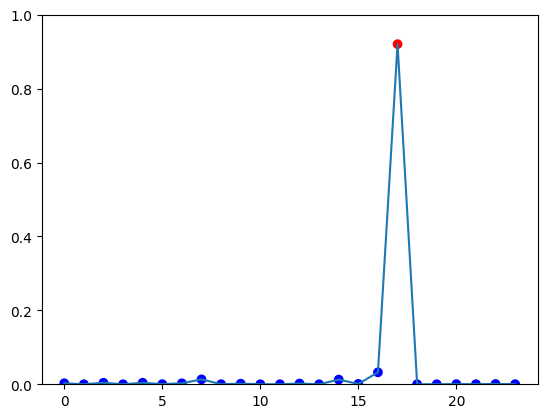

 The skin around the veins on my legs is dry and flaky. It seems there is a major bruise and my legs have started to swell.

True Label : Varicose Veins = 17


In [34]:
#Hint la función de remove_stopwords acepta un arreglo con arreglos "#0000FF"

from IPython.display import clear_output
import matplotlib.pyplot as plt
from numpy.random import randn
from time import sleep
import pandas as pd

num = 69

frase = dat["text"][num].split(" ")
in_frase = ""
color = "#0000FF"
colors = [color] * 24
colors[dat['label_encoded'][num]] = "#FF0000"

for palabra in frase:
  in_frase = in_frase + " " + palabra
  input = tokenize_and_pad(remove_stopwords([in_frase]), tokenizer)
  pred = model_GRU.predict(input)
  sleep(2)
  clear_output(wait=True)
  plt.scatter(range(24),pred[0],color=colors)
  plt.plot(pred[0])
  plt.ylim([0,1])
  plt.show()
  print(in_frase)

print()
print(f"True Label : {dat['label'][num]} = {dat['label_encoded'][num]}")

Este grafico muestra la evolución de la probabilidad del índice 17, siendo dicho índice la clase correcta. Como se aprecia, en medida que aumentamos el número de palabras disminuye la probabilidad del resto y aumenta esta respectivamente, demostrando la confianza que tiene el modelo para predecir correctamente con un numero grande de palabras.

### Ejemplo frase custom

In [37]:
# Creamos una frase que contenga palabras del vocabulario
frase_custom = "Pain Pain Pain Pain Pain Pain Pain Pain Pain Pain Pain Pain Pain Pain"

# Tokenizamos y quitamos las stop words
input = tokenize_and_pad(remove_stopwords([frase_custom]), tokenizer)

# Realizamos la prediccion
pred = model_GRU.predict(input)

# Obtenemos la clasificacion
clase = np.argmax(pred)

# Retornamos el indice como nombre de la clase
print(f'La prediccion es: {label_encoder.inverse_transform([np.argmax(pred).tolist()])}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
La prediccion es: ['Typhoid']


Ejemplo para detallar la prueba de oraciones nuevas. Si el vocabulario de la tokenizacion es extenso, se puede cubrir un horizonte grande de posibilidades de oraciones nuevas.

## Actividad 2
Entrene un nuevo modelo cambiando la capa GRU por una capa LTSM y compare los resultados
![texto del vínculo](https://miro.medium.com/v2/resize:fit:720/format:webp/1*7cMfenu76BZCzdKWCfBABA.png)

In [38]:
# build the model with GRU layer
model_LTSM = tf.keras.Sequential([
    tf.keras.Input(shape=(max_length,)),  # Especifica la forma de entrada
    tf.keras.layers.Embedding(input_dim=3000, output_dim=256),
    tf.keras.layers.LSTM(64, go_backwards=True, dropout=0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(24, activation='softmax')])

model_LTSM.summary()
model_LTSM.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 50, 256)        │       768,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 853,048 (3.25 MB)

 Trainable params: 853,048 (3.25 MB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model_LTSM.fit(train_sequences, train_labels, epochs=30, validation_data=(val_sequences, val_labels), callbacks=get_callbacks())

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.1079 - loss: 3.1556 - val_accuracy: 0.2083 - val_loss: 2.9764 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2265 - loss: 2.7433 - val_accuracy: 0.4500 - val_loss: 1.9929 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6898 - loss: 1.5171 - val_accuracy: 0.7667 - val_loss: 1.0195 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9236 - loss: 0.6203 - val_accuracy: 0.8708 - val_loss: 0.5742 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9818 - loss: 0.2335 - val_accuracy: 0.9000 - val_loss: 0.4088 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9968 - loss: 0.0986 - val_accuracy: 0.9000 - val_loss: 0.3597 - learning_rate: 0.0010
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9987 - loss: 0.0542 - val_accu

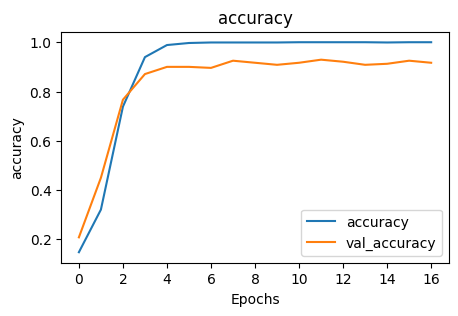

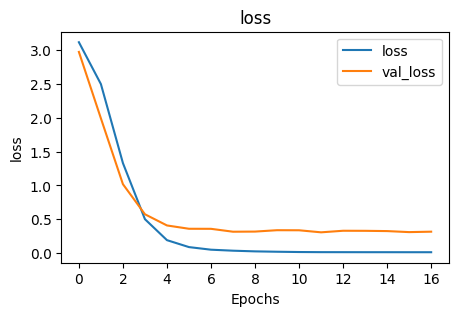

In [40]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Notar que este modelo alcanza valores mayores de accuracy, siendo superiores a 0.8.